In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import json
import numpy as np
import pandas as pd
import string
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
import sys
import seaborn
from sklearn import preprocessing
#import lightgbm as lgb 

In [2]:
millionsub = pd.read_csv('..\\data\\extracted\\million_song_subset.csv')
msdset = pd.read_csv('..\\data\\extracted\\msdset.csv')

hot100 = pd.read_csv('..\\data\\extracted\\hot-100.csv')
albumcat = pd.read_csv('..\\data\\extracted\\catalog-albums.csv')
songsale = pd.read_csv('..\\data\\extracted\\digital-song-sales.csv')
popsongs = pd.read_csv('..\\data\\extracted\\pop-songs.csv')
radiosongs = pd.read_csv('..\\data\\extracted\\radio-songs.csv')
streamingsongs = pd.read_csv('..\\data\\extracted\\streaming-songs.csv')
topabsale = pd.read_csv('..\\data\\extracted\\top-album-sales.csv')
youtubesongs = pd.read_csv('..\\data\\extracted\\youtube.csv')

In [3]:
msdset[(msdset.song_hotness>0) & (msdset.post_year>0)][['song_hotness','post_year']]

,song_hotness,post_year
1,0.262309,1997
20,0.561309,1982
26,0.215080,1993
28,0.610642,2007
32,0.450184,2004
34,0.710586,1996
41,0.645448,2008
42,0.212045,1998
45,0.706510,2008
47,0.428702,2004


Text(0, 0.5, 'hotness')

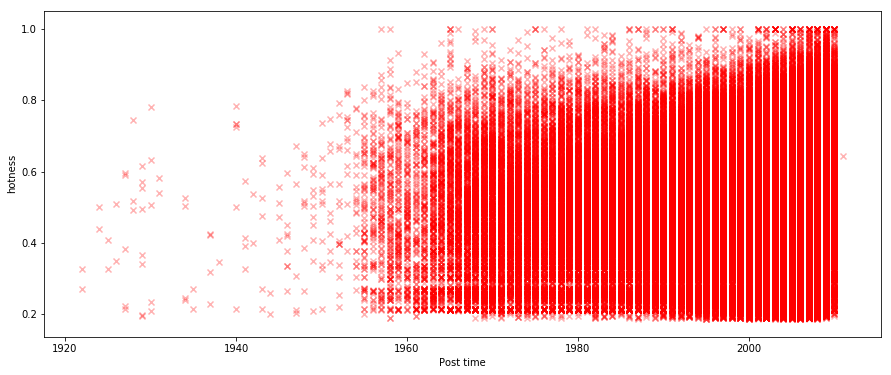

In [4]:
fig = plt.figure(figsize = (15,6))
plt.scatter(msdset[(msdset.song_hotness>0) & (msdset.post_year>0)]['post_year'],
            msdset[(msdset.song_hotness>0) & (msdset.post_year>0)]['song_hotness'],marker='x', c='r', alpha=0.3)
plt.xlabel('Post time')
plt.ylabel('hotness')

In [5]:
postyeardf = msdset[msdset['post_year']>0][['post_year', 'artist_name', 'title']]
t=postyeardf.groupby(['artist_name','title'])['post_year'].count()
t[t>1]

artist_name                                   title                                       
'Til Tuesday                                  Love In A Vacuum                                2
                                              The Other End (Of The Telescope)                2
                                              Voices Carry                                    2
                                              Why Must I                                      2
+44                                           Baby Come On                                    2
                                              Cliff Diving                                    2
                                              Lycanthrope                                     2
                                              Weatherman                                      2
                                              When Your Heart Stops Beating                   5
-123min.                                     

In [23]:
t[t>1].describe()

count    4.000000
mean     3.250000
std      1.892969
min      2.000000
25%      2.000000
50%      2.500000
75%      3.750000
max      6.000000
Name: post_year, dtype: float64

In [24]:
postyeardf = msdset[(msdset.title=='Do You Love Me')][['post_year', 'artist_name', 'title']]
postyeardf

,post_year,artist_name,title
16958,0,Mud,Do You Love Me
27396,2006,Thee Midniters,Do You Love Me
96229,1964,The Hollies,Do You Love Me
134242,0,The Wrights,Do You Love Me
182990,0,Kiss,Do You Love Me
186617,1962,The Contours with Joe Billingslea,Do You Love Me
221731,2006,John Holt,Do You Love Me
252422,1962,The Contours,Do You Love Me
276407,0,Kiss,Do You Love Me
360886,1962,The Contours,Do You Love Me


In [22]:
postyeardf = msdset[(msdset.title=='Do You Love Me')&(msdset.artist_name=='The Contours')][['post_year', 'artist_name', 'title']]
postyeardf

,post_year,artist_name,title
252422,1962,The Contours,Do You Love Me
360886,1962,The Contours,Do You Love Me
361956,1962,The Contours,Do You Love Me
653337,1962,The Contours,Do You Love Me
744294,1962,The Contours,Do You Love Me
866625,1962,The Contours,Do You Love Me


In [10]:
padf = msdset[(msdset['post_year']>0)&(msdset['artist_name']!='')][['post_year', 'artist_name', 'title']]
t2=padf.groupby(['artist_name','title'])['post_year'].count()
t2[t2>1]

artist_name                                   title                                       
'Til Tuesday                                  Love In A Vacuum                                2
                                              The Other End (Of The Telescope)                2
                                              Voices Carry                                    2
                                              Why Must I                                      2
+44                                           Baby Come On                                    2
                                              Cliff Diving                                    2
                                              Lycanthrope                                     2
                                              Weatherman                                      2
                                              When Your Heart Stops Beating                   5
-123min.                                     

In [17]:
t2.sort_values(ascending=False)

artist_name                       title                                   
Der Blutharsch                    Untitled                                    87
7000 Dying Rats                   Untitled                                    31
Three Drives                      Greece 2000                                 28
Age Of Love                       The Age Of Love                             20
Yves Deruyter                     Infinity                                    19
Deep Forest                       Sweet Lullaby                               18
2-4 Grooves feat. Reki D.         Relax                                       16
System F                          Cry                                         16
The Killers                       Human                                       15
Oceanic                           Insanity                                    14
Pussy 2000                        It's Gonna Be Alright                       14
Danielle Bollinger                

In [7]:
hot100

,title,chart_date,artist_name,peak_rank,last_rank,on_chart_weeks,current_rank,is_new
0,Girls Like You,2018-11-10,Maroon 5 Featuring Cardi B,1,1,23,1,False
1,Sicko Mode,2018-11-10,Travis Scott,2,2,13,2,False
2,Happier,2018-11-10,Marshmello & Bastille,3,4,11,3,False
3,Lucid Dreams,2018-11-10,Juice WRLD,2,3,25,4,False
4,Better Now,2018-11-10,Post Malone,3,5,27,5,False
5,ZEZE,2018-11-10,Kodak Black Featuring Travis Scott & Offset,2,6,3,6,False
6,Youngblood,2018-11-10,5 Seconds Of Summer,7,7,22,7,False
7,Drip Too Hard,2018-11-10,Lil Baby & Gunna,4,8,7,8,False
8,Without Me,2018-11-10,Halsey,9,12,4,9,False
9,Mo Bamba,2018-11-10,Sheck Wes,10,16,10,10,False


In [ ]:
sniff = hot100[['title','chart_date','artist_name']]


In [8]:
last_time = sniff['chart_date'].groupby([sniff['title'], sniff['artist_name']]).max()
first_time = sniff['chart_date'].groupby([sniff['title'], sniff['artist_name']]).min()

NameError: name 'sniff' is not defined

In [ ]:
lifespan=pd.DataFrame({'first_time':first_time,'last_time':last_time})
lifespan['first_time']=pd.to_datetime(lifespan['first_time'],format='%Y-%m-%d')
lifespan['last_time']=pd.to_datetime(lifespan['last_time'],format='%Y-%m-%d')

In [ ]:
lifespan['dayspan']=(lifespan['last_time']-lifespan['first_time']).dt.days

In [ ]:
lifespan['yearspan']=lifespan['dayspan']/365.25

In [ ]:
lifespan.sort_values(by=['dayspan','title'], ascending=False).head(20)

In [ ]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Endurance (Years)', size=16)
ax1.set_ylabel('# of Songs (grouped by singers)', size=16)
ax1.set_title('Distribution of Songs\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax1.patch.set_facecolor("white")
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
plt.hist(lifespan['yearspan'], bins=60,facecolor="green", edgecolor="black", log=True, alpha=0.5)

In [ ]:
song_last_time = sniff['chart_date'].groupby([sniff['title']]).max()
song_first_time = sniff['chart_date'].groupby([sniff['title']]).min()

In [ ]:
song_lifespan=pd.DataFrame({'first_time':song_first_time,'last_time':song_last_time})
song_lifespan['first_time']=pd.to_datetime(song_lifespan['first_time'],format='%Y-%m-%d')
song_lifespan['last_time']=pd.to_datetime(song_lifespan['last_time'],format='%Y-%m-%d')

In [ ]:
song_lifespan['dayspan']=(song_lifespan['last_time']-song_lifespan['first_time']).dt.days

In [ ]:
song_lifespan['yearspan']=song_lifespan['dayspan']/365.25

In [ ]:
song_lifespan.sort_values(by=['dayspan','title'], ascending=False).head(20)

In [ ]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Endurance (Years)', size=16)
ax1.set_ylabel('# of Songs', size=16)
ax1.set_title('Distribution of Songs\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax1.patch.set_facecolor("white")
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
plt.hist(song_lifespan['yearspan'], bins=60,facecolor="purple", edgecolor="black", log=True, alpha=0.5)

In [ ]:
singer_sniff = hot100[['chart_date','artist_name']]

In [ ]:
singer_last_time = singer_sniff['chart_date'].groupby([singer_sniff['artist_name']]).max()
singer_first_time = singer_sniff['chart_date'].groupby([singer_sniff['artist_name']]).min()

In [ ]:
singer_lifespan=pd.DataFrame({'first_time':singer_first_time,'last_time':singer_last_time})
singer_lifespan['first_time']=pd.to_datetime(singer_lifespan['first_time'],format='%Y-%m-%d')
singer_lifespan['last_time']=pd.to_datetime(singer_lifespan['last_time'],format='%Y-%m-%d')

In [ ]:
singer_lifespan['dayspan']=(singer_lifespan['last_time']-singer_lifespan['first_time']).dt.days

In [ ]:
singer_lifespan['yearspan']=singer_lifespan['dayspan']/365.25

In [ ]:
singer_lifespan.sort_values(by=['dayspan'], ascending=False).head(20)

In [ ]:
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Endurance (Years)', size=16)
ax1.set_ylabel('# of Singers', size=16)
ax1.set_title('Distribution of Singers\' Endurance', size=16)
plt.grid(axis = 'y', linestyle = '--', color='gray')
ax1.patch.set_facecolor("white")
ax1.spines['left'].set_color('black')
ax1.spines['bottom'].set_color('black')
plt.hist(singer_lifespan['yearspan'], bins=60,facecolor="red", edgecolor="black", log=True, alpha=0.5)

In [ ]:
lifespan

In [ ]:
sniff.sort_values(axis=0,by=['title','chart_date'])